<center>
<img src="https://hsto.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg"/>
## Open Machine Learning Course [mlcourse.ai](https://mlcourse.ai)
<center>

Author: Vitaly Radchenko (@vradchenko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment # 5 (demo)</center>
## <center>Logistic Regression and Random Forest in the credit scoring problem</center>  

In this assignment, you will build models and answer questions using data on credit scoring.

Please write your code in the cells with the "Your code here" placeholder. Then, answer the questions in the [form](https://docs.google.com/forms/d/1gKt0DA4So8ohKAHZNCk58ezvg7K_tik26d9QND7WC6M/edit).

Let's start with a warm-up exercise.

**Question 1.** There are 5 jurors in a courtroom. Each of them can correctly identify the guilt of the defendant with 70% probability, independent of one another. What is the probability that the jurors will jointly reach the correct verdict if the final decision is by majority vote?

1. 70.00%
2. 83.20%
3. 83.70%
4. 87.50%

83.70%

Great! Let's move on to machine learning.

## Credit scoring problem

#### Problem

Predict whether the customer will repay their credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

#### Data description

| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |


In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# To have bigger plot sizes and use sns output in pandas plot-commands.
sns.set(rc={'figure.figsize': (10, 7)})

In [3]:
def fill_nan(table):
    """ Replace NaN values with a median for each column in the table. """
    new_table = pd.DataFrame()
    for col in table.columns:
        new_table[col] = table[col].fillna(table[col].median())
    return new_table

### Look at the data:

In [4]:
data = pd.read_csv('../input/credit_scoring_sample.csv')
print(data.shape)
data.head()

(45063, 8)


,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Check the class balance:

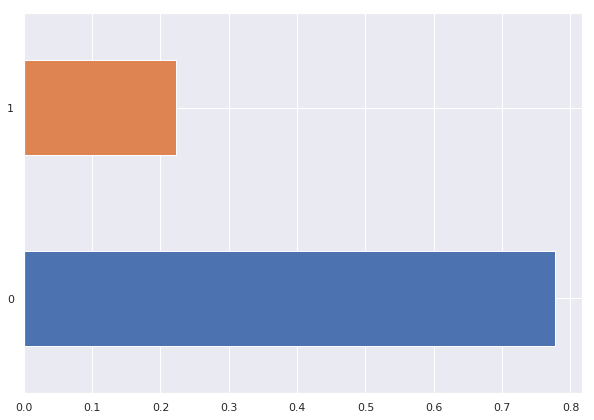

In [6]:
data['SeriousDlqin2yrs'].value_counts(normalize=True).plot(kind='barh');

In [7]:
# Replace NaN values with a median:
table = fill_nan(data)

Separate the target variable and input features:

In [8]:
X = table.drop('SeriousDlqin2yrs', axis='columns')
y = table['SeriousDlqin2yrs']

X.shape, y.shape

((45063, 7), (45063,))

## Bootstrapping

**Question 2.** Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. Use the example from the article as reference, if needed. Also, use `np.random.seed(0)` as before. What is the resulting interval estimate?

1. 52.59 – 52.86
2. 45.71 – 46.13
3. 45.68 – 46.17
4. 52.56 – 52.88

In [9]:
def get_bootstrap_samples(data, n_samples):
    """ Return subsets according to bootstrap. """
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha/2, 100*(1 - alpha/2)])
    return boundaries

didnt_pay = X[y == 1]['age'].values    # in version >= 0.24 - to_numpy()

np.random.seed(0)

# Generate subsets and compute mean.
mean_scores = [np.mean(s) for s in get_bootstrap_samples(didnt_pay, 1000)]

# Interval estimate of the average age.
print('Average age: mean interval', stat_intervals(mean_scores, 0.1).round(2))    # 90% confidence

Average age: mean interval [45.71 46.13]


## Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Now, we will create a `LogisticRegression` model and use `class_weight='balanced'` to make up for our unbalanced classes.

In [11]:
logit = LogisticRegression(random_state=5, class_weight='balanced')

Let's try to find the best regularization coefficient, which is the coefficient `C` for logistic regression. Then, we will have an optimal model that is not overfitted and is a good predictor of the target variable.

In [12]:
parameters = {'C': np.power(10.0, np.arange(-4, 2))}

In order to find the optimal value of `C`, let's apply stratified 5-fold validation and look at the *ROC AUC* against different values of the parameter `C`. Use the `StratifiedKFold` function for this: 

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

One of the important metrics of model quality is the *Area Under the Curve (AUC)*. *ROC AUC* varies from 0 to 1. The closer ROC AUC to 1, the better the quality of the classification model.

**Question 3.** Perform a *Grid Search* with the scoring metric "roc_auc" for the parameter `C`. Which value of the parameter `C` is optimal? 

1. 0.0001
2. 0.001
3. 0.01
4. 0.1
5. 1
6. 10

In [14]:
search = GridSearchCV(logit, parameters, cv=skf, scoring='roc_auc', verbose=1, n_jobs=-1)
search.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.1s finished
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=5,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [15]:
search.best_score_, search.best_params_

(0.795409411236062, {'C': 0.001})

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with 100 trees and balance target classes.
rf = RandomForestClassifier(n_estimators=100, random_state=42, 
                            class_weight='balanced', n_jobs=-1)

We will search for the best parameters among the following values:

In [17]:
parameters = {'max_features': [1, 2, 4],
              'min_samples_leaf': [3, 5, 7, 9],
              'max_depth': [5,10,15]}

Also, we will use the stratified k-fold validation again. You should still have the `skf` variable.

**Question 8.** How much higher is the *ROC AUC* of the best random forest model than that of the best logistic regression on validation?

1. 4%
2. 3%
3. 2%
4. 1%

In [18]:
search_rf = GridSearchCV(rf, parameters, cv=skf, scoring='roc_auc', verbose=1, n_jobs=-1)
search_rf.fit(X, y)

search_rf.best_score_, search_rf.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.7min finished


(0.8350557986441058,
 {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 7})

**Question 9.** What feature has the weakest impact in the Random Forest model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

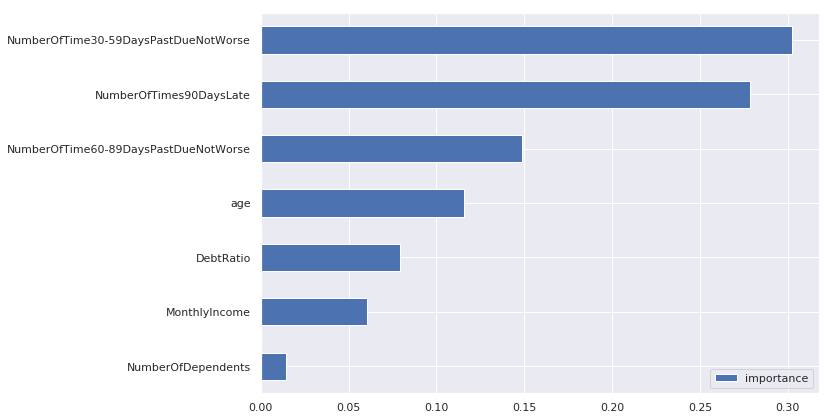

In [19]:
importances = pd.DataFrame(search_rf.best_estimator_.feature_importances_,
                           index=X.columns,
                           columns=['importance'])
importances.sort_values('importance').plot(kind='barh')

**Question 10.** What is the most significant advantage of using *Logistic Regression* versus *Random Forest* for this problem?

1. Spent less time for model fitting;
2. Fewer variables to iterate;
3. Feature interpretability;
4. Linear properties of the algorithm.

3. Feature interpretability

## Bagging

In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

parameters = {'max_features': [2, 3, 4],
              'max_samples': [0.5, 0.7, 0.9],
              'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

**Question 11.** Fit a bagging classifier with `random_state=42`. For the base classifiers, use 100 logistic regressors and use `RandomizedSearchCV` instead of `GridSearchCV`. It will take a lot of time to iterate over all 54 variants, so set the maximum number of iterations for `RandomizedSearchCV` to 20. Don't forget to set the parameters `cv` and `random_state=1`. What is the best *ROC AUC* you achieve?

1. 80.75%
2. 80.12%
3. 79.62%
4. 76.50%

In [21]:
clf = BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'),
                        n_estimators=100,
                        random_state=42)
rnd_search = RandomizedSearchCV(clf, parameters, n_iter=20, cv=skf, scoring='roc_auc',
                                verbose=1, random_state=1, n_jobs=-1)
rnd_search.fit(X, y)

rnd_search.best_score_, rnd_search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.3min finished
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.8076172570918905,
 {'max_samples': 0.7, 'max_features': 2, 'base_estimator__C': 0.001})

**Question 12.** Give an interpretation of the best parameters for bagging. Why are these values of `max_features` and `max_samples` the best?

1. For bagging it's important to use as few features as possible;
2. Bagging works better on small samples;
3. Less correlation between single models;
4. The higher the number of features, the lower the loss of information.

3. less correlation between single models